In [9]:
%reset -f

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE3 import lhs  # For Latin Hypercube Sampling
import matplotlib.patches as patches


torch.manual_seed(425)
np.random.seed(425)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\chris\AppData\Local\Temp\ipykernel_41560\3648128690.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_inlet_boundary = torch.tensor(4/squaresize * inlet_coords[:,1] * (squaresize - inlet_coords[:,1])).to(device)  # parabolic inflow


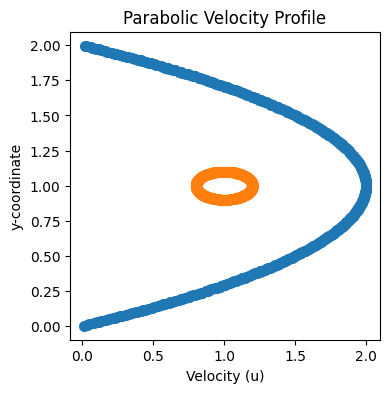

In [11]:
# Setting the device for computation
N1, N2, N3, N4, N5, N6 = 114, 436, 1642, 6381, 25315, 100266
N = N5
# Ellipse points
E = int(N/100)
# Inflow points
I = int(N/70)
squaresize = 2
mu = 1
center_x, center_y = squaresize/2, squaresize/2
radius_x, radius_y = squaresize/10, 0.5*squaresize/10

# Create collocation points using LHS
lhs_samples = lhs(2, samples= N)
x_collocation = lhs_samples[:, 0]   
y_collocation = lhs_samples[:, 1] 
collocation_coords = torch.tensor(np.column_stack((x_collocation, y_collocation)), dtype=torch.float32).to(device)

# Generate ellipse boundary points
theta = np.linspace(0, 2 * np.pi, E)
x_ellips = center_x + radius_x * np.cos(theta)
y_ellips = center_y + radius_y * np.sin(theta)
ellips_coords = torch.tensor(np.column_stack((x_ellips, y_ellips)), dtype=torch.float32).to(device)

# Apply no-slip condition for the ellips boundary (u = 0, v = 0)
u_ellips_boundary = torch.zeros(E).to(device)
v_ellips_boundary = torch.zeros(E).to(device)

# Generate inlet boundary points and apply parabolic inlet condition 
lhs_samples_inlet = squaresize* lhs(2, samples=I)
x_inlet = lhs_samples_inlet[:, 0] 
y_inlet = lhs_samples_inlet[:, 1] 
inlet_coords = torch.tensor(np.column_stack((x_inlet, y_inlet)), dtype=torch.float32).to(device)
u_inlet_boundary = torch.tensor(4/squaresize * inlet_coords[:,1] * (squaresize - inlet_coords[:,1])).to(device)  # parabolic inflow 
#u_inlet_boundary = 2* torch.ones(I).to(device) # u = 1 on left wall with parabolic profile
v_inlet_boundary = torch.zeros(I).to(device)  # v = 0 m/s

# top and bottom boundary
lhs_samples_top = squaresize* lhs(2, samples=I)
x_top = lhs_samples_inlet[:, 0] 
y_top = lhs_samples_inlet[:, 1] 
top_coords = torch.tensor(np.column_stack((x_top, y_top)), dtype=torch.float32).to(device)
u_top_boundary = torch.zeros(I).to(device)  # u = 0 m/s
v_top_boundary = torch.zeros(I).to(device)  # v = 0 m/s
#
lhs_samples_bot = squaresize* lhs(2, samples=I)
x_bot = lhs_samples_inlet[:, 0] 
y_bot = lhs_samples_inlet[:, 1] 
bot_coords = torch.tensor(np.column_stack((x_bot, y_bot)), dtype=torch.float32).to(device)
u_bot_boundary = torch.zeros(I).to(device)  # u = 0 m/s
v_bot_boundary = torch.zeros(I).to(device)  # v = 0 m/s

# Plotting the inflow
x = inlet_coords[:, 0].cpu().numpy()  # x-coordinates (should all be 0)
y = inlet_coords[:, 1].cpu().numpy()  # y-coordinates (0 to 1)
u = u_inlet_boundary.cpu().numpy()    # u-velocity (parabolic profile)
v = v_inlet_boundary.cpu().numpy()    # v-velocity (should all be 0)

# Additional plot to show the exact parabolic profile
plt.figure(figsize=(4, 4))
plt.scatter(u, y, linewidth=2)
plt.scatter(x_ellips,y_ellips, linewidth=2)
plt.title("Parabolic Velocity Profile")
plt.xlabel("Velocity (u)")
plt.ylabel("y-coordinate")
plt.show()

In [12]:

# Define the Stokes PINN model
class StokesPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.layer1 = nn.Linear(2, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer5 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 3)

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.activation(self.layer5(x))

        return self.output_layer(x)  # [u, v, p]
    
model = StokesPINN().to(device)

def split_uvp(out):
    u = out[:, 0:1]
    v = out[:, 1:2]
    p = out[:, 2:3]
    return u, v, p

# Ensure input has gradients enabled
def gradients(u, x, order=1):
    for _ in range(order):
        u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u

def compute_residuals(model, x, mu):
    x.requires_grad_(True)
    output = model(x)
    u, v, p = output[:, 0], output[:, 1], output[:, 2]

    # First-order derivatives
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_y = grad_u[:, 0], grad_u[:, 1]

    grad_v = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x, v_y = grad_v[:, 0], grad_v[:, 1]

    grad_p = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_x, p_y = grad_p[:, 0], grad_p[:, 1]

    # Second-order derivatives (Laplacians)
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0]
    v_yy = torch.autograd.grad(v_y, x, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1]

    # PDE residuals (Stokes equations: -Δu + ∇p = f)
    f1 = p_x - mu*(u_xx + u_yy)
    f2 = p_y - mu*(v_xx + v_yy)
    div_u = u_x + v_y

    return f1, f2 , div_u



In [13]:
# Boundary loss function for applying boundary conditions
def boundary_loss(model, boundary_coords, u_boundary, v_boundary):
    u_pred, v_pred = model(boundary_coords)[:, 0], model(boundary_coords)[:, 1]
    loss_Bc =  ((u_pred - u_boundary) ** 2 + (v_pred - v_boundary) ** 2).mean()
    return loss_Bc

In [14]:
# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)  # Optional learning rate scheduler
num_epochs = 2000 #Number of training epochs
loss_history = []
fix_idx = torch.argmin(torch.norm(collocation_coords - torch.tensor([[0.0, 0.0]]), dim=1))

# Training loop with gradient clipping and improved logging
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute physics-based and boundary losses
    f1, f2, div_u = compute_residuals(model, collocation_coords, mu)
    phy_loss = (f1**2).mean() + (f2**2).mean() + 1*(div_u**2).mean()
    bound_loss_ellipse = boundary_loss(model, ellips_coords, u_ellips_boundary, v_ellips_boundary)
    bound_loss_inlet = boundary_loss(model, inlet_coords, u_inlet_boundary, v_inlet_boundary)
    bound_loss_top = boundary_loss(model, top_coords, u_top_boundary, v_top_boundary)
    bound_loss_bot = boundary_loss(model, bot_coords, u_bot_boundary, v_bot_boundary)

    # fixing the pressure
    x_fix = collocation_coords[fix_idx].unsqueeze(0)
    p_fix = model(x_fix)[:, 2]  # extract pressure at that point
    loss_pressure = (p_fix - 0.0)**2  # fix pressure to 0.0 at 0,0

    total_loss = 1*phy_loss + 1*bound_loss_ellipse + 1*bound_loss_inlet + 1*bound_loss_top+ 1*bound_loss_bot + 1*loss_pressure

    total_loss.backward()
    
    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    optimizer.step()
    scheduler.step()  # Optional scheduler step
    loss_history.append(total_loss.item())

    # Print progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.item():.6f}, Physics Loss = {phy_loss.item():.6f}, "
              f"Ellipse BC Loss = {bound_loss_ellipse.item():.6f}, Inlet BC Loss = {bound_loss_inlet.item():.6f}")


Epoch 0: Total Loss = 1.908800, Physics Loss = 0.000601, Ellipse BC Loss = 0.023159, Inlet BC Loss = 1.835193


KeyboardInterrupt: 

In [ ]:
# Visualization function to plot the ellipse
def plot_ellips(ax, r1= 2*radius_x, r2 = 2*radius_y, center=(center_x,center_y)):
    ellips = patches.Ellipse(center, r1, r2, color='black', alpha=1.0)
    ax.add_patch(ellips)

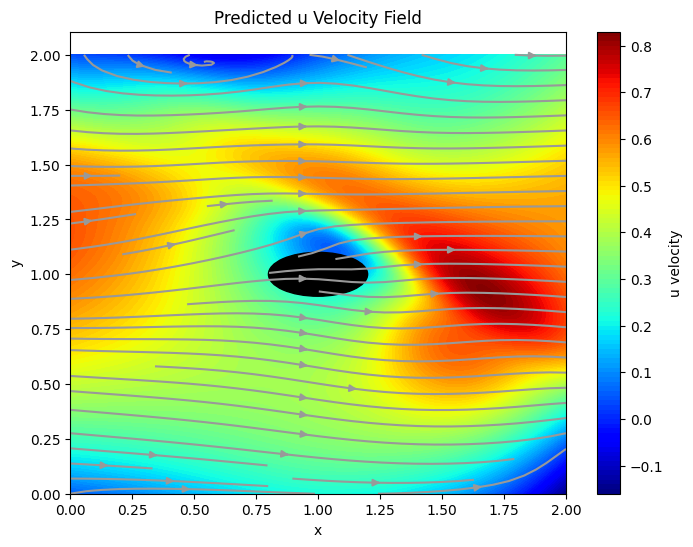

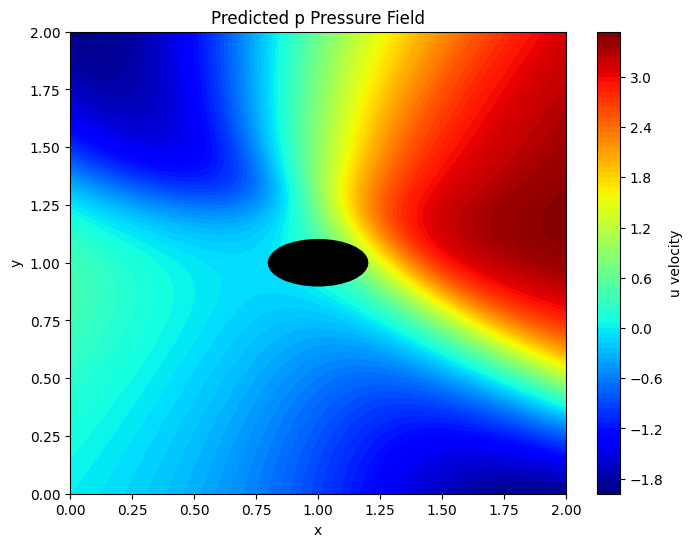

In [ ]:
# Improved visualization with gradient color maps
with torch.no_grad():
    x_plot, y_plot = np.meshgrid(np.linspace(0, squaresize, 100), np.linspace(0, squaresize, 100))
    coords_plot = torch.tensor(np.column_stack((x_plot.ravel(), y_plot.ravel())), dtype=torch.float32).to(device)
    outputs = model(coords_plot)
    u_pred = outputs[:, 0].cpu().numpy().reshape(100, 100)
    v_pred = outputs[:, 1].cpu().numpy().reshape(100, 100)
    p_pred = outputs[:, 2].cpu().numpy().reshape(100, 100)

    # Plot u velocity field with gradient colors
    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(x_plot, y_plot, u_pred, levels=100, cmap='jet')  # Increased levels for smoother gradients
    ax.streamplot(x_plot, y_plot, u_pred, v_pred, density=1, color=(0.6, 0.6, 0.6))
    plt.colorbar(contour, label="u velocity")
    plot_ellips(ax)
    ax.set_title("Predicted u Velocity Field")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Plot p pressure field with gradient colors
    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(x_plot, y_plot, p_pred, levels=100, cmap='jet') 
    plt.colorbar(contour, label="u velocity")
    plot_ellips(ax)
    ax.set_title("Predicted p Pressure Field")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()
    